## 1) Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from lightgbm import LGBMClassifier, Booster
from shaphypetune import BoostBoruta
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
from sklearn.metrics import roc_auc_score, confusion_matrix, auc
from sklearn.ensemble import BaggingClassifier

warnings.simplefilter('ignore')

## 2) Data preparation

In [14]:
df = pd.read_csv('cs-training.csv').drop(columns = 'Unnamed: 0')
df['SeriousDlqin2yrs'].replace({0:False,1:True})
df.shape

(150000, 11)

### 2.1) Removing outliers

In [15]:
df['RevolvingUtilizationOfUnsecuredLines'].loc[
    df['RevolvingUtilizationOfUnsecuredLines'] > 1] = np.nan
df = df[df['NumberOfTime30-59DaysPastDueNotWorse'] < 96]
df = df[df['NumberOfTime60-89DaysPastDueNotWorse'] < 96]
df = df[df['NumberOfTimes90DaysLate'] < 96]
df = df.loc[(df['DebtRatio'] <= 1.75)]
df = df.loc[(df['age'] >= 20)]
df.shape

(118241, 11)

### 2.2) Filling Null Values

In [16]:
df.isna().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines    2706
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           1734
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                       449
dtype: int64

In [17]:
imputer = KNNImputer(n_neighbors=3)
df_imputed = imputer.fit_transform(df)
df1 = pd.DataFrame(df_imputed, columns=df.columns)

In [19]:
df1.isna().sum().sum()

0

### 2.3) Balancing dataset

In [20]:
X = df1.drop(columns='SeriousDlqin2yrs')
y = df1[['SeriousDlqin2yrs']]

over = SMOTE(sampling_strategy=0.1, k_neighbors=3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)

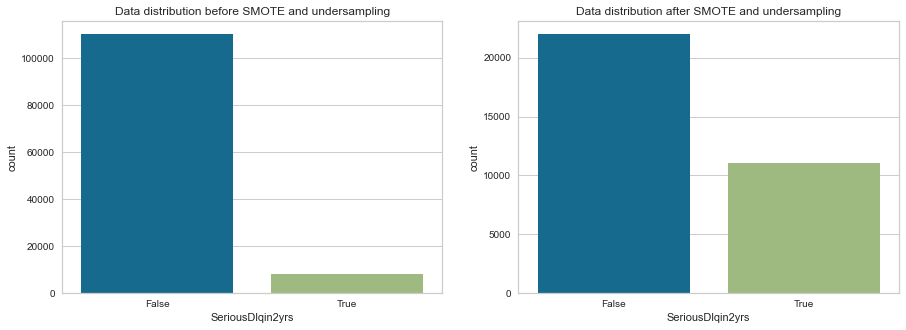

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x="SeriousDlqin2yrs", data=df)
plt.title('Data distribution before SMOTE and undersampling')

plt.subplot(1, 2, 2)
sns.countplot(x="SeriousDlqin2yrs", data=y.replace({0:False,1:True}))
plt.title('Data distribution after SMOTE and undersampling')

plt.show()

## 3) Modelling

In [52]:
def ROC_AUC(clf, X_train, y_train, X_test, y_test):
    
    pred_prob = clf.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    print('AUC score: ', auc_score)
    
    visualizer = ROCAUC(clf)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True)

clf = LGBMClassifier(is_unbalance = True)
clf.fit(X_train, y_train)
ROC_AUC(clf, X_train, y_train, X_test, y_test)

LGBMClassifier(is_unbalance=True)

AUC score:  0.884843281555013


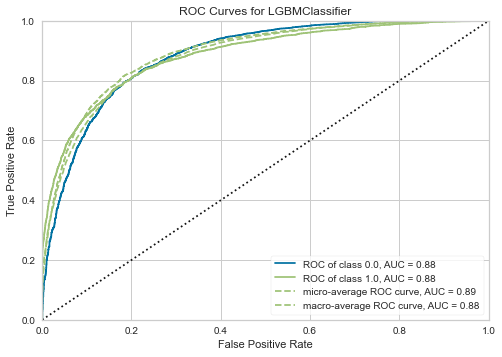

In [54]:
ROC_AUC(clf, X_train, y_train, X_test, y_test)

### 3.1) Hyperparameter tuning

#### 3.2.1) num_estimators

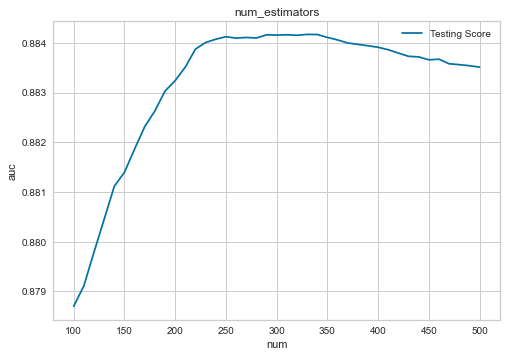

In [55]:
num_estimators = range(100, 501, 10)
test_scores = []
for num_estimator in num_estimators:
    lgbm = LGBMClassifier(num_leaves=60,
                          learning_rate=0.02,
                          n_estimators=num_estimator,
                          is_unbalance=True)
    lgbm.fit(X_train, y_train)
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_estimators, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('num_estimators')
ax.legend(loc='best')
plt.show()

In [56]:
num_estimator = num_estimators[test_scores.index(max(test_scores))]
num_estimator

330

#### 3.2.2) learning_rates

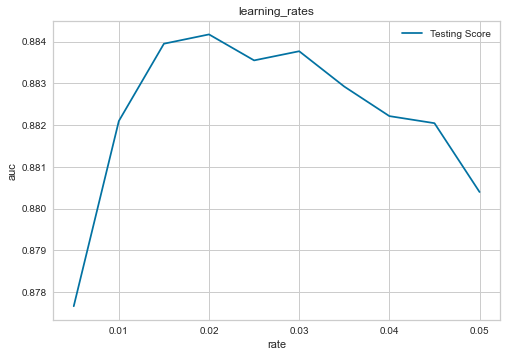

In [57]:
learning_rates = np.arange(1, 11, 1)
learning_rates = learning_rates / 200.0
test_scores = []
for learning_rate in learning_rates:
    lgbm = LGBMClassifier(num_leaves=60,
                          learning_rate=learning_rate,
                          n_estimators=num_estimator,
                          is_unbalance=True)
    lgbm.fit(X_train, y_train)
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(learning_rates, test_scores, label='Testing Score')
ax.set_xlabel(r'rate')
ax.set_ylabel(r'auc')
ax.set_title('learning_rates')
ax.legend(loc='best')
plt.show()

In [58]:
leanring_rate = learning_rates[test_scores.index(max(test_scores))]
learning_rate

0.05

#### 3.2.3) max_bins

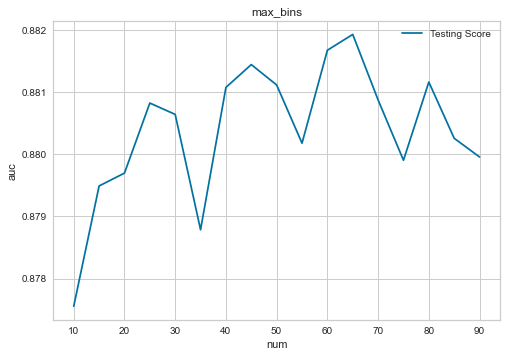

In [89]:
max_bins = range(10, 91, 5)
test_scores = []
for max_bin in max_bins:
    lgbm = LGBMClassifier(max_bin=max_bin,
                          num_leaves=60,
                          learning_rate=learning_rate,
                          n_estimators=num_estimator,
                          is_unbalance=True)
    lgbm.fit(X_train, y_train)
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(max_bins, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('max_bins')
ax.legend(loc='best')
plt.show()

In [90]:
max_bin = max_bins[test_scores.index(max(test_scores))]
max_bin

65

#### 3.2.4) num_leaves

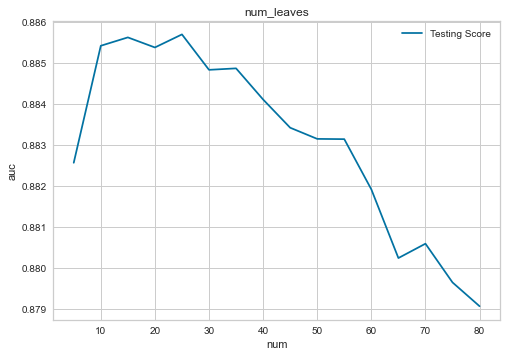

In [91]:
num_leaves = range(5, 81, 5)
test_scores = []
for num_leave in num_leaves:
    lgbm = LGBMClassifier(num_leaves=num_leave,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimator,
                         is_unbalance = True)
    lgbm.fit(X_train, y_train)
    pre_y1 = lgbm.predict_proba(X_train)[:, 1]
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_leaves, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('num_leaves')
ax.legend(loc='best')
plt.show()

In [92]:
num_leave = num_leaves[test_scores.index(max(test_scores))]
num_leave

25

#### 3.2.5) max_depht

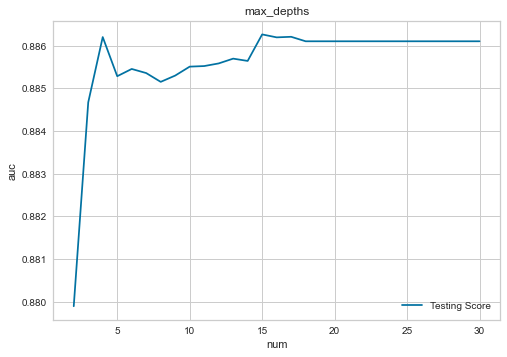

In [63]:
max_depths = range(2, 31, 1)
test_scores = []
for max_depth in max_depths:
    lgbm = LGBMClassifier(max_depth=max_depth,
                          num_leaves=num_leave,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimator)
    lgbm.fit(X_train, y_train)
    pre_y1 = lgbm.predict_proba(X_train)[:, 1]
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(max_depths, test_scores, label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('max_depths')
ax.legend(loc='best')
plt.show()

In [64]:
max_depths[test_scores.index(max(test_scores))]

15

#### 3.2.6) feature_fractions

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

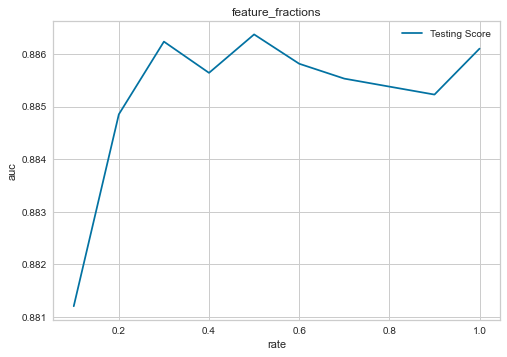

In [94]:
feature_fractions = np.arange(1, 11, 1)
feature_fractions = feature_fractions / 10.0
test_scores = []
for feature_fraction in feature_fractions:
    lgbm = LGBMClassifier(max_depth=max_depth,
                          num_leaves=num_leave,
                          max_bin=max_bin,
                          learning_rate=learning_rate,
                          n_estimators=num_estimator,
                          feature_fraction=feature_fraction)
    lgbm.fit(X_train, y_train)
    pre_y1 = lgbm.predict_proba(X_train)[:, 1]
    pre_y2 = lgbm.predict_proba(X_test)[:, 1]
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(feature_fractions, test_scores, label='Testing Score')
ax.set_xlabel(r'rate')
ax.set_ylabel(r'auc')
ax.set_title('feature_fractions')
ax.legend(loc='best')
plt.show()

In [95]:
feature_fraction = feature_fractions[test_scores.index(max(test_scores))]
feature_fraction

0.5

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
AUC score:  0.8863722560420008


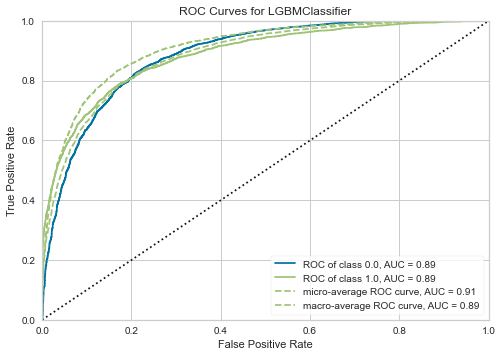

In [97]:
clf_tuned = LGBMClassifier(max_depth=max_depth,
                           num_leaves=num_leave,
                           max_bin=max_bin,
                           learning_rate=learning_rate,
                           n_estimators=num_estimator,
                           feature_fraction=feature_fraction)

clf_tuned.fit(X_train, y_train)
ROC_AUC(clf_tuned, X_train, y_train, X_test, y_test)

AUC score:  0.8864526616919607


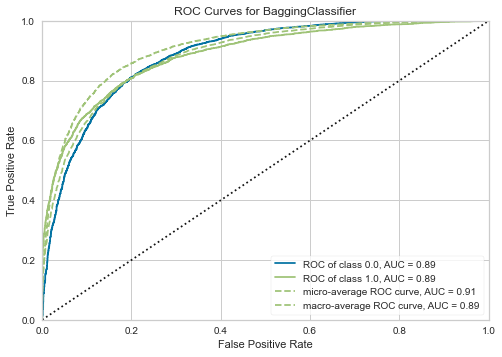

In [101]:
clf = BaggingClassifier(base_estimator=clf_tuned,
                        n_estimators=10,
                        random_state=0).fit(X_train, y_train)
ROC_AUC(clf, X_train, y_train, X_test, y_test)

## 4) Evaluation

In [67]:
clf_tuned = LGBMClassifier(max_depth=max_depth,
                           num_leaves=num_leave,
                           max_bin=max_bin,
                           learning_rate=learning_rate,
                           n_estimators=num_estimator,
                           feature_fraction=feature_fraction)
clf_tuned.fit(X_train, y_train)
pre_y = clf_tuned.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


AUC score:  0.8863722560420008


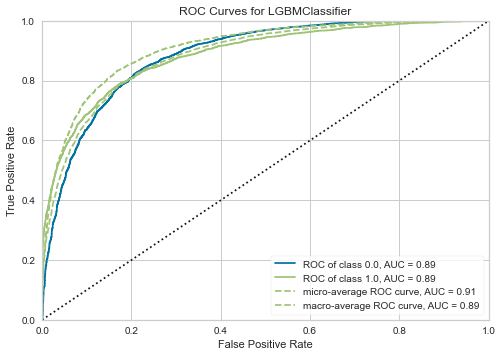

In [68]:
ROC_AUC(clf_tuned, X_train, y_train, X_test, y_test)

In [69]:
test = pd.read_csv('cs-test.csv').drop(columns = 'Unnamed: 0')
y_pred = clf_tuned.predict_proba(test.drop(columns='SeriousDlqin2yrs'))
submission = pd.read_csv('sampleEntry.csv')
submission['Probability'] = y_pred
submission['Probability'] = 1-submission['Probability'] 
submission.to_csv('submission.csv',index=False)